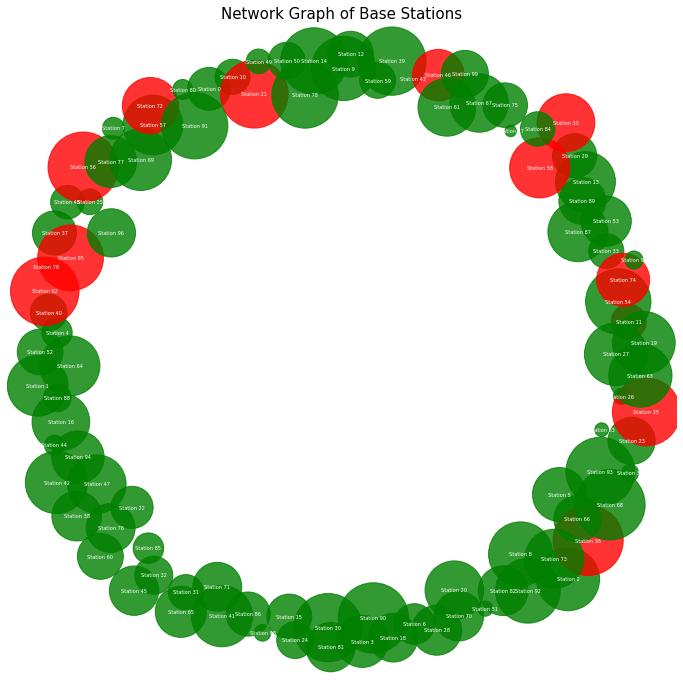

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopy.distance

# 节点添加：为每个基站添加一个节点，并存储相关属性。
# 边添加：根据基站之间的地理距离添加边，条件是距离小于 5 公里。
# 可视化：使用 matplotlib 和 networkx 进行网络图的绘制，节点颜色代表故障状态（红色表示有故障，绿色表示无故障），大小反映了用户数量。


# 加载数据
data_path = 'datatransfer/Final_Combined_Data.csv'
data = pd.read_csv(data_path)

# 创建图
G = nx.Graph()

# 添加节点和属性
for idx, row in data.iterrows():
    G.add_node(row['cell_id'],
               timestamp=row['timestamp'],
               latitude=row['latitude'],
               longitude=row['longitude'],
               RSRP=row['RSRP'],
               RSRQ=row['RSRQ'],
               fault=row['fault'],
               model=row['model'],
               user_count=row['user_count'],
               traffic=row['traffic'])

# 添加边，此处可以根据实际情况添加逻辑，比如相邻的基站或特定条件下的基站关系
for node1 in G.nodes(data=True):
    for node2 in G.nodes(data=True):
        if node1 != node2:
            dist = geopy.distance.geodesic((node1[1]['latitude'], node1[1]['longitude']),
                                           (node2[1]['latitude'], node2[1]['longitude'])).km
            if dist < 5:  # 假设距离小于5公里的基站有边
                G.add_edge(node1[0], node2[0], distance=dist)


# 假设 G 是你的图对象
pos = nx.spring_layout(G)  # 为节点设置布局

# 节点和边的可视化属性
node_sizes = [G.nodes[node]['user_count']*10 for node in G.nodes]  # 调整节点大小
node_colors = ['red' if G.nodes[node]['fault'] else 'green' for node in G.nodes]  # 节点颜色
labels = {node: f"Station {node}" for node in G.nodes}

# 绘制图形
plt.figure(figsize=(12, 12))  # 调整图形大小
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
nx.draw_networkx_labels(G, pos, labels, font_size=5, font_family='sans-serif', font_color='white')  # 调整字体大小和颜色
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# 边的标签
edge_labels = nx.get_edge_attributes(G, 'distance')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)  # 调整边标签字体大小

plt.title('Network Graph of Base Stations', size=15)
plt.axis('off')  # 关闭坐标轴


# 保存图形到文件
plt.savefig('datatransfer/knowledgegraph.png', format='png', dpi=300)  # 指定路径和文件格式

plt.show()

In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# 将 NetworkX 图转化为 PyTorch Geometric 数据结构
# 节点特征: RSRP, RSRQ, user_count, traffic
for node in G.nodes:
    G.nodes[node]['feature'] = [
        G.nodes[node]['RSRP'],
        G.nodes[node]['RSRQ'],
        G.nodes[node]['user_count']
#         G.nodes[node]['traffic']
    ]

# 标签: fault (0 无故障, 1 有故障)
for node in G.nodes:
    G.nodes[node]['label'] = int(G.nodes[node]['fault'])

# 将 NetworkX 图转化为 PyTorch Geometric 格式
data = from_networkx(G)

# 将特征和标签转换为 PyTorch 张量
data.x = torch.tensor([G.nodes[node]['feature'] for node in G.nodes], dtype=torch.float)
data.y = torch.tensor([G.nodes[node]['label'] for node in G.nodes], dtype=torch.long)


In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# 定义一个简单的 GCN 模型
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 初始化模型
model = GCN(in_channels=data.x.shape[1], hidden_channels=16, out_channels=2)  # 2 表示有2个类别：有故障/无故障


In [7]:
import torch.optim as optim

# 选择交叉熵损失函数和Adam优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
def train(data):
    model.train()
    optimizer.zero_grad()  # 梯度清零
    out = model(data)  # 前向传播
    loss = criterion(out, data.y)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重
    return loss.item()

# 开始训练
for epoch in range(200):  # 200个训练epoch
    loss = train(data)
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 0, Loss: 7.473726749420166
Epoch 20, Loss: 0.9890919327735901
Epoch 40, Loss: 0.4461524188518524
Epoch 60, Loss: 0.3593215048313141
Epoch 80, Loss: 0.3334326446056366
Epoch 100, Loss: 0.3402632176876068
Epoch 120, Loss: 0.3338988125324249
Epoch 140, Loss: 0.33057093620300293
Epoch 160, Loss: 0.3294007480144501
Epoch 180, Loss: 0.3281486928462982


In [8]:
def test(data):
    model.eval()
    correct = 0
    out = model(data)
    pred = out.argmax(dim=1)  # 预测类别
    correct = pred.eq(data.y).sum().item()
    acc = correct / data.num_nodes
    print(f'Accuracy: {acc * 100:.2f}%')

# 测试模型
test(data)


Accuracy: 88.00%


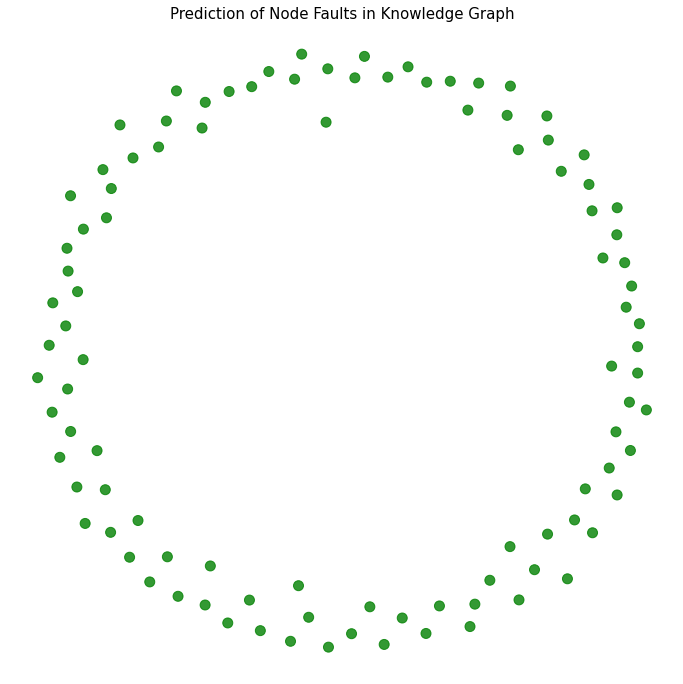

In [9]:
import matplotlib.pyplot as plt

# 预测结果
model.eval()
out = model(data)
pred = out.argmax(dim=1).numpy()

# 根据预测结果重新定义节点颜色
node_colors = ['red' if pred[i] == 1 else 'green' for i in range(len(pred))]

# 绘制知识图谱，并展示预测结果
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
plt.title('Prediction of Node Faults in Knowledge Graph', size=15)
plt.axis('off')
plt.show()
